In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',False)
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv('data_clean.csv')
df = df[df['tipe'] == 'Rumah']
df = df.drop(
    ['tipe','Unnamed: 0'],
    axis = 1
)
df = df.drop_duplicates()

In [3]:
df_copy = df.copy()

In [4]:
cat = [i for i in df_copy.columns if df_copy[i].dtypes in ['O','bool']]
num = [i for i in df.columns if df[i].dtypes in ['int','float']]
df_copy[cat] = df_copy[cat].astype('O')

In [5]:
from feature_engine.encoding import OrdinalEncoder as OE

In [6]:
oe = OE(variables = [i for i in cat])
oe.fit(df_copy,df_copy['harga'])

OrdinalEncoder(variables=['deskripsi', 'kecamatan', 'garasi', 'kolam_renang',
                          'taman', 'gym'])

In [7]:
df_copy = oe.transform(df_copy)

In [8]:
from sklearn.preprocessing import StandardScaler as ss

In [9]:
scale = ss()
scale.fit(df_copy)
df_copy = scale.transform(df_copy)

In [10]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [11]:
model = KMeans()
visualizer = KElbowVisualizer(
    model,
    k = (2,10),
    metric = 'calinski_harabasz',
    timing = False
)

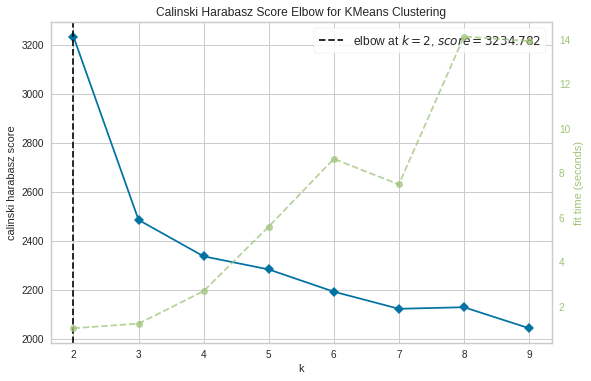

In [12]:
visualizer.fit(df_copy)
visualizer.show()

In [13]:
model = KMeans(n_clusters=2)
cluster = model.fit_predict(df_copy)

In [14]:
df_copy = pd.DataFrame(df_copy)

In [15]:
df_copy.columns = df.columns

In [16]:
df_copy['cluster'] = cluster
df['cluster'] = cluster

In [17]:
def set_cluster(df):
    a = df[df['cluster'] == 0]['harga'].mean()
    b = df[df['cluster'] == 1]['harga'].mean()
    if a>b:
        df['cluster']=df['cluster'].apply(lambda x:1 if x==0 else 0)
    return df

In [18]:
df_copy = set_cluster(df_copy)
df = set_cluster(df)

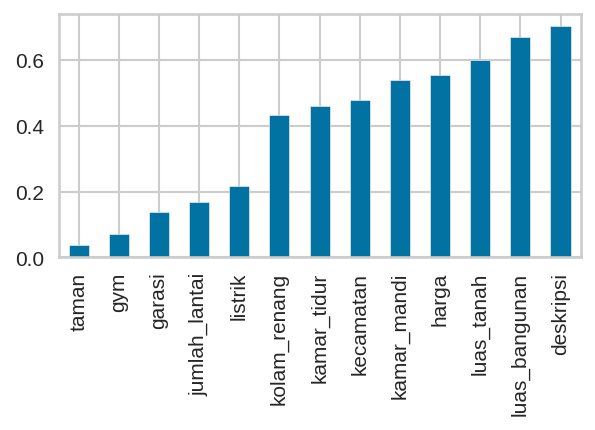

In [19]:
plt.figure(figsize=(4,2), dpi=150)
df_copy.corr()['cluster'][:-1].sort_values().plot(kind='bar')
plt.show()

Cluster 0

In [20]:
df[df['cluster'] ==0][cat].describe()

,deskripsi,kecamatan,garasi,kolam_renang,taman,gym
count,9543,9543,9543,9543,9543,9543
unique,9543,42,2,2,2,2
top,dijual rumah 2lokasi strategis di curug raya d...,Duren Sawit,True,False,False,False
freq,1,874,8058,9131,7529,9486


In [21]:
df[df['cluster'] ==0].describe()

,kamar_mandi,kamar_tidur,luas_bangunan,luas_tanah,harga,listrik,jumlah_lantai,cluster
count,9543.000000,9543.000000,9543.000000,9543.000000,9.543000e+03,9543.00000,9543.000000,9543.0
mean,3.338154,4.197003,166.958818,136.966572,2.802919e+09,4766.82888,1.990464,0.0
std,1.122351,1.249256,90.649054,86.384860,2.127106e+09,7526.75915,0.628577,0.0
min,1.000000,1.000000,21.000000,22.000000,9.500000e+07,130.00000,1.000000,0.0
25%,3.000000,3.000000,100.000000,83.000000,1.400000e+09,2200.00000,2.000000,0.0
50%,3.000000,4.000000,150.000000,115.000000,2.200000e+09,2200.00000,2.000000,0.0
75%,4.000000,5.000000,210.000000,165.500000,3.500000e+09,4400.00000,2.000000,0.0
max,9.000000,11.000000,800.000000,1125.000000,3.050000e+10,85000.00000,5.000000,0.0


In [ ]:
for i in cat:
    print(i)
    df[df['cluster'] ==0][i].value_counts().plot.bar()
    plt.show()

deskripsi


In [ ]:
for i in num:
    print(i)
    df[df['cluster'] ==0][i].plot.hist(bins = 100)
    plt.show()

Cluster 1

In [ ]:
df[df['cluster'] == 1][cat].describe()

In [ ]:
df[df['cluster'] == 1].describe()

In [ ]:
for i in cat:
    print(i)
    df[df['cluster'] == 1][i].value_counts().plot.bar()
    plt.show()

In [ ]:
for i in num:
    print(i)
    df[df['cluster'] ==1][i].plot.hist(bins = 100)
    plt.show()

Compare cluster 1 dan cluster 0

In [ ]:
for i in num:
    print(i)
    plt.figure(figsize=(20,10),dpi=200)
    sns.histplot(data=df, x=i, bins=100, hue='cluster')
    plt.show()

In [ ]:
df_cat = pd.concat([df[cat],df['cluster']], axis = 1)
for i in cat:
    if i != 'kecamatan':
        print(i)
        df_cat = pd.concat([df[cat],df['cluster']], axis = 1)
        df_cat = pd.DataFrame(df_cat.groupby(['cluster'])[i].value_counts())
        df_cat.columns = ['count']
        df_cat['total_cluster'] = df_cat.groupby(['cluster'])['count'].transform('sum')
        df_cat['persentase'] = df_cat['count'] / df_cat['total_cluster']*100
        df_cat = df_cat.reset_index()
        sns.barplot(
            data = df_cat,
            x = i,
            y = 'persentase',
            hue = 'cluster'
        )
        plt.show()

In [ ]:
df_kecamatan = df.groupby(['cluster','kecamatan'])[['harga']].count().reset_index()
df_kecamatan.columns = ['cluster', 'kecamatan', 'count']
df_kecamatan['total_cluster'] = df_kecamatan.groupby(['cluster'])['count'].transform('sum')
df_kecamatan['persentase'] = df_kecamatan['count']/df_kecamatan['total_cluster']*100
df_kecamatan = df_kecamatan[['cluster','kecamatan','persentase']]
plt.figure(figsize=(22,22),dpi=200)
sns.barplot(data=df_kecamatan, y='kecamatan',x='persentase', hue='cluster', order = df['kecamatan'].value_counts().index)
plt.title('Kecamatan per Cluster')
plt.show()

## Simpulan
- Dengan menggunakan metrics calinski harabasz, diperoleh cluster terbaik adalah 2 cluster. dengan cluster 0 sebanyak 10005 rumah dan cluster 1 sebanyak 2261 rumah. 